In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns

sns.set_theme(context='talk', 
              style='whitegrid', 
              palette='Set2',
              font_scale=1.4, 
              rc={'figure.figsize': (14, 6)})

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly
pio.templates.default = 'plotly_white+presentation'



import scipy.optimize
import scipy.constants as sc

hbarc = sc.hbar*sc.speed_of_light/sc.giga/sc.electron_volt / sc.femto

from scipy.interpolate import InterpolatedUnivariateSpline


import json
import os
import glob

# parameters

In [3]:
df_conf = pd.read_csv('../data/CLS_conf_inf.csv')
df_conf['a2 [fm2]'] = df_conf['a [fm]'].apply(lambda x: x**2)
df_conf['a_inv [GeV]'] = (hbarc / df_conf['a [fm]']).round(3) # add lattice unit
df_conf

,Label,N_f,beta,kappa,size_L,size_T,bdy.cond.,a [fm],m_pi [MeV],L [fm],m_pi L,m_B [GeV],N_conf,N_tsrc,N_meas,N_LapH,a2 [fm2],a_inv [GeV]
0,N300,3,3.70,0.137000,48,128,open,0.0498,422,2.4,5.1,1.19,2047,12,24564,32,0.002480,3.962
1,N202,3,3.55,0.137000,48,128,open,0.0642,412,3.1,6.4,1.17,899,8,10788,68,0.004122,3.074
2,H200,3,3.55,0.137000,32,96,open,0.0642,419,2.1,4.4,1.19,2000,8,16000,20,0.004122,3.074
3,B450,3,3.46,0.136890,32,64,periodic,0.0762,417,2.4,5.2,1.18,1612,8,25762,32,0.005806,2.590
4,H101,3,3.40,0.136760,32,96,open,0.0865,417,2.8,5.9,1.16,2016,4,12096,48,0.007482,2.281
5,U103,3,3.40,0.136760,24,128,open,0.0865,414,2.1,4.4,1.18,5658,5,45264,20,0.007482,2.281
6,A653,3,3.34,0.136572,24,48,periodic,0.0992,424,2.4,5.1,1.16,5050,4,40400,32,0.009841,1.989
7,E5,2,5.30,0.136250,32,64,periodic,0.0658,436,2.1,4.7,1.29,2000,4,16000,30,0.004330,2.999
8,E1,2,5.30,0.135500,32,64,periodic,0.0658,978,2.1,10.4,2.03,168,8,2688,30,0.004330,2.999


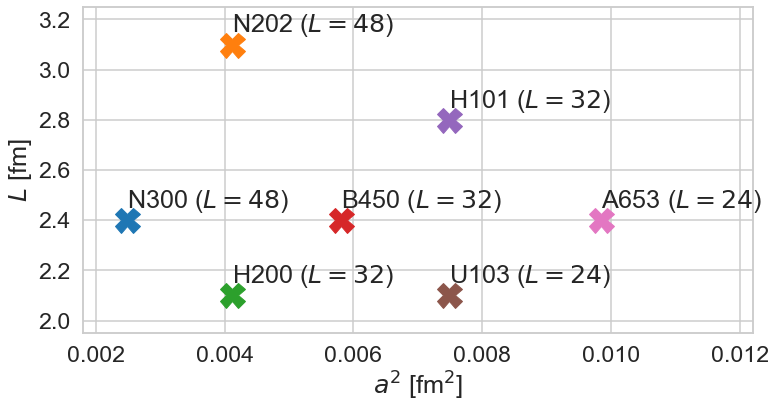

In [4]:
lat_unit_dic = df_conf.set_index('Label')['a [fm]'].to_dict()
a_inv_dic = df_conf.set_index('Label')['a_inv [GeV]'].to_dict()
L_fm_dic = df_conf.set_index('Label')['L [fm]'].to_dict()
L_dic = df_conf.set_index('Label')['size_L'].to_dict()
pion_mass_dic = df_conf.set_index('Label')['m_pi [MeV]'].to_dict()
baryon_mass_dic = df_conf.set_index('Label')['m_B [GeV]'].to_dict()
label_list = list(df_conf['Label'])

with sns.color_palette('tab10'):
    fig, ax = plt.subplots(figsize=(12, 6))
    for label in label_list:
        if label in ['E5', 'E1']: continue
        a2 = lat_unit_dic.get(label)**2
        L_fm = L_fm_dic.get(label)
        ax.plot(a2, L_fm, 'X', ms=25)
        ax.text(a2, L_fm+0.05, fr'{label} ($L = {L_dic.get(label)}$)')
    ax.set(xlabel=r'$a^2$ [fm$^2$]', ylabel='$L$ [fm]', xlim=(0.0018, 0.0122), ylim=(1.95, 3.25))

In [5]:
df_conf.query('Label in ["N300", "B450", "A653"]')

,Label,N_f,beta,kappa,size_L,size_T,bdy.cond.,a [fm],m_pi [MeV],L [fm],m_pi L,m_B [GeV],N_conf,N_tsrc,N_meas,N_LapH,a2 [fm2],a_inv [GeV]
0,N300,3,3.70,0.137000,48,128,open,0.0498,422,2.4,5.1,1.19,2047,12,24564,32,0.002480,3.962
3,B450,3,3.46,0.136890,32,64,periodic,0.0762,417,2.4,5.2,1.18,1612,8,25762,32,0.005806,2.590
6,A653,3,3.34,0.136572,24,48,periodic,0.0992,424,2.4,5.1,1.16,5050,4,40400,32,0.009841,1.989


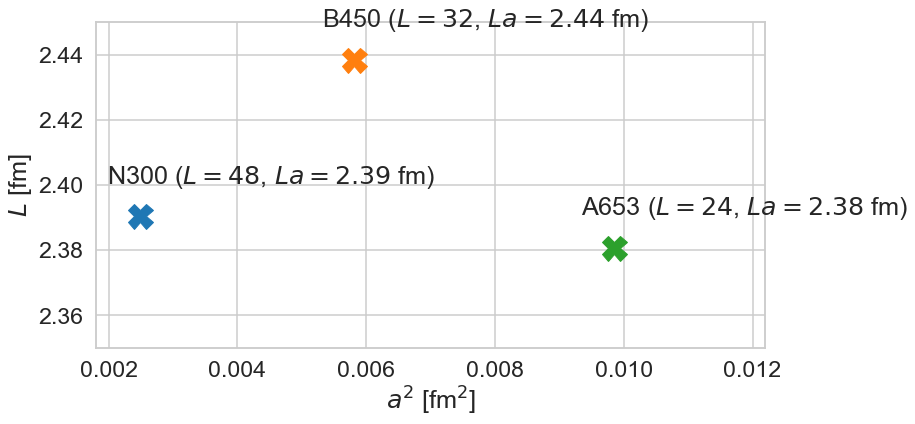

In [6]:
with sns.color_palette('tab10'):
    fig, ax = plt.subplots(figsize=(12, 6))
    for label in ['N300', 'B450', 'A653']:
        a2 = lat_unit_dic.get(label)**2
        a = lat_unit_dic.get(label)
        L = L_dic.get(label)
        L_fm = L * a
        ax.plot(a2, L_fm, 'X', ms=25)
        ax.text(a2-0.0005, L_fm+0.01, fr'{label} ($L = {L_dic.get(label)}$, $La = {L_fm:.2f}$ fm)')
    ax.set(xlabel=r'$a^2$ [fm$^2$]', ylabel='$L$ [fm]', xlim=(0.0018, 0.0122), ylim=(2.35, 2.45))

# preprocessing Fig. 5

In [7]:
# set origins
# 0 -> 89.2086, 1.5 -> 226.495
conv_x = lambda x: 0 + 1.5 * (x - 89.2086) / (226.495 - 89.2086)
# -0.5 -> 169.105, 3.0 -> 9.141
conv_y = lambda y: -0.5 + (3.0 + 0.5) * (y - 169.105) / (9.141 - 169.105)

# -0.2 -> 82.3441, 0.2 -> 147.719
conv_x2 = lambda x: -0.2 + (0.2 + 0.2) * (x - 82.3441) / (147.719 - 82.3441)
# -0.4 -> 72.096, 0.0 -> 20.599
conv_y2 = lambda y: -0.4 + (0.0 + 0.4) * (y - 72.096) / (20.599 - 72.096)

In [8]:
raw_data_a0099 = {
    'P001_1': {
        'xy': np.array([
            [223.06, 84.38],
            [220.68, 89.32],
            [226.14, 88.91]
        ]).mean(axis=0),
        'xys': np.array([
            [220.9, 93.26],
            [223.28, 87.56],
            [225.55, 81.56],
            [225.68, 81.18]
        ])
    },
    'P000_1': {
        'xy': np.array([
            [191.72, 96.8],
            [189.05, 101.58],
            [194.52, 101.5]
        ]).mean(axis=0),
        'xys': np.array([
            [189.37, 104.88],
            [191.73, 100.02],
            [193.98, 94.9],
            [194.16, 94.46]
        ])
    },
    'P111_0': {
        'xy': np.array([
            [107.49, 148.78],
            [112.43, 146.04],
            [112.44, 151.51]
        ]).mean(axis=0),
        'xys': np.array([
            [107.89, 150.8],
            [112.49, 147.61],
            [113.82, 146.63]
        ])
    },
    'P011_0': {
        'xy': np.array([
            [85.13, 159.37],
            [90.06, 156.98],
            [89.67, 162.44]
        ]).mean(axis=0),
        'xys': np.array([
            [86.19, 160.81],
            [90.39, 158.34]
        ])
    },
    'P001_0': {
        'xy': np.array([
            [63.51, 167.9],
            [68.55, 165.76],
            [67.68, 171.2]
        ]).mean(axis=0),
        'xys': np.array([
            [64.9, 169.17],
            [68.39, 167.38]
        ])
    },
    'P002_0': {
        'xy': np.array([
            [45.18, 174.11],
            [50.27, 172.07],
            [49.49, 177.49]
        ]).mean(axis=0),
        'xys': np.array([
            [46.75, 175.3],
            [49.88, 173.77]
        ])
    },
    'P000_0': {
        'xy': np.array([
            [41.22, 175.5734],
            [46.35, 173.64],
            [45.46, 179.05]
        ]).mean(axis=0),
        'xys': np.array([
            [42.73, 176.81],
            [45.96, 175.34]
        ])
    },
    'ere': np.array([
        [41.62, 177.5],
        [52.85, 173.54],
        [64.08, 169.33],
        [75.31, 164.87],
        [86.54, 160.14],
        [97.77, 155.16],
        [109, 149.92],
        [120.24, 144.43],
        [131.47, 138.68],
        [142.7, 132.67],
        [153.93, 126.41],
        [165.16, 119.89],
        [176.39, 113.11],
        [187.62, 106.08],
        [198.85, 98.79],
        [210.09, 91.24],
        [221.32, 83.44],
        [232.55, 75.38],
        [243.78, 67.06],
        [244.8, 66.29]
    ])
}

In [9]:
raw_data_a0076 = {
    'P001_1': {
        'xy': np.array([226.471, 57.718]),
        'xys': np.array([
            [225.52, 61.7],
            [227.36, 53.77],
            [227.42, 53.48]
        ])
    },
    'P000_1': {
        'xy': np.array([191.9265, 88.538]),
        'xys': np.array([
            [191.03, 91.06],
            [192.82, 85.88]
        ])
    },
    'P111_0': {
        'xy': np.array([121.723, 139.084]),
        'xys': np.array([
            [120.46, 140.25],
            [122.99, 137.88]
        ])
    },
    'P011_0': {
        'xy': np.array([101.3467, 150.237]),
        'xys': np.array([
            [100.44, 150.97],
            [102.25, 149.49]
        ])
    },
    'P001_0': {
        'xy': np.array([79.9539, 160.286]),
        'xys': np.array([
            [79.25, 160.79],
            [80.65, 159.78]
        ])
    },
    'P002_0': {
        'xy': np.array([58.7545, 169.011]),
        'xys': np.array([
            [58.14, 169.41],
            [59.37, 168.6]
        ])
    },
    'P000_0': {
        'xy': np.array([57.2036, 169.528]),
        'xys': np.array([
            [56.6, 169.92],
            [57.81, 169.13]
        ])
    },
    'ere': np.array([
        [41.62, 173.88],
        [49.78, 171.45],
        [57.95, 168.76],
        [66.12, 165.82],
        [74.29, 162.63],
        [82.46, 159.18],
        [90.63, 155.49],
        [98.79, 151.54],
        [106.96, 147.35],
        [115.13, 142.9],
        [123.3, 138.21],
        [131.47, 133.26],
        [139.63, 128.06],
        [147.8, 122.61],
        [155.97, 116.91],
        [164.14, 110.96],
        [172.31, 104.75],
        [180.48, 98.3],
        [189.67, 90.74],
        [198.85, 82.86],
        [208.04, 74.66],
        [217.23, 66.15],
        [226.42, 57.31],
        [235.61, 48.16],
        [244.8, 38.7]
    ])
}

In [10]:
raw_data_a0050 = {
    'P001_1': {
        'xy': np.array([
            [234.57, 26.13],
            [239.75, 24.33],
            [238.72, 29.71]
        ]).mean(axis=0),
        'xys': np.array([
            [235.69, 38.44],
            [237.37, 28.67],
            [238.98, 17.99],
            [239.67, 12.92]
        ])
    },
    'P000_1': {
        'xy': np.array([
            [199.5, 64.13],
            [203.32, 68.06],
            [204.81, 62.79]
        ]).mean(axis=0),
        'xys': np.array([
            [201.07, 70.95],
            [204.01, 58.34]
        ])
    },
    'P111_0': {
        'xy': np.array([
            [132.09, 124.72],
            [133.58, 129.99],
            [137.4, 126.06]
        ]).mean(axis=0),
        'xys': np.array([
            [131.55, 130.27],
            [134.65, 126.56],
            [137.16, 123.26]
        ])
    },
    'P011_0': {
        'xy': np.array([
            [109.18, 145.71],
            [108.2, 140.32],
            [113.36, 142.18]
        ]).mean(axis=0),
        'xys': np.array([
            [108.49, 144.49],
            [111.54, 141.38],
            [112.01, 140.87]
        ])
    },
    'P001_0': {
        'xy': np.array([
            [84.95, 152.24],
            [85.6, 157.68],
            [89.99, 154.4]
        ]).mean(axis=0),
        'xys': np.array([
            [85.31, 156.13],
            [88.2, 153.51],
            [88.39, 153.33]
        ])
    },
    'P002_0': {
        'xy': np.array([
            [61.34, 162.78],
            [61.74, 168.25],
            [66.27, 165.17]
        ]).mean(axis=0),
        'xys': np.array([
            [61.96, 166.32],
            [64.27, 164.42]
        ])
    },
    'P000_0': {
        'xy': np.array([
            [60.36, 162.91],
            [60.76, 168.38],
            [65.29, 165.31]
        ]).mean(axis=0),
        'xys': np.array([
            [60.72, 166.66],
            [63.39, 164.47],
            [63.56, 164.32]
        ])
    },
    'ere': np.array([
        [41.62, 170.91],
        [48.76, 169.09],
        [55.91, 167.01],
        [63.06, 164.66],
        [70.2, 162.05],
        [77.35, 159.17],
        [84.5, 156.03],
        [91.65, 152.62],
        [98.79, 148.95],
        [105.94, 145.01],
        [113.09, 140.81],
        [120.24, 136.34],
        [127.38, 131.61],
        [134.53, 126.61],
        [141.68, 121.35],
        [148.82, 115.82],
        [155.97, 110.03],
        [163.12, 103.98],
        [170.26, 97.65],
        [177.41, 91.07],
        [185.58, 83.22],
        [193.75, 75.02],
        [201.92, 66.48],
        [210.09, 57.59],
        [218.25, 48.35],
        [226.42, 38.77],
        [234.59, 28.84],
        [242.76, 18.57],
        [244.8, 15.94]
    ])
}

In [11]:
raw_data_a0 = {
    'ere': np.array([
        [41.62, 168.69],
        [47.74, 167.34],
        [53.87, 165.76],
        [59.99, 163.95],
        [66.12, 161.9],
        [72.25, 159.61],
        [78.37, 157.1],
        [84.5, 154.35],
        [90.63, 151.36],
        [96.75, 148.14],
        [102.88, 144.68],
        [109, 140.99],
        [115.13, 137.07],
        [121.26, 132.91],
        [127.38, 128.51],
        [134.53, 123.09],
        [141.68, 117.35],
        [148.82, 111.29],
        [155.97, 104.91],
        [163.12, 98.21],
        [170.26, 91.19],
        [177.41, 83.85],
        [184.56, 76.2],
        [191.71, 68.22],
        [198.85, 59.93],
        [206, 51.31],
        [213.15, 42.38],
        [220.29, 33.13],
        [228.46, 22.16],
        [236.63, 10.78],
        [244.786, -1]
    ]),
    'ere_band': np.array([
        [41.62, 167.28, 170.1],
        [43.66, 166.93, 169.6],
        [45.7, 166.56, 169.07],
        [47.74, 166.15, 168.53],
        [49.78, 165.72, 167.96],
        [51.83, 165.26, 167.37],
        [53.87, 164.77, 166.75],
        [55.91, 164.25, 166.11],
        [57.95, 163.7, 165.45],
        [59.99, 163.12, 164.77],
        [62.04, 162.51, 164.07],
        [64.08, 161.87, 163.34],
        [66.12, 161.2, 162.59],
        [68.16, 160.5, 161.82],
        [70.2, 159.77, 161.03],
        [72.25, 159.01, 160.22],
        [74.29, 158.22, 159.38],
        [76.33, 157.4, 158.53],
        [78.37, 156.54, 157.65],
        [80.41, 155.66, 156.75],
        [82.46, 154.74, 155.83],
        [84.5, 153.8, 154.89],
        [86.54, 152.82, 153.93],
        [88.58, 151.82, 152.94],
        [90.63, 150.78, 151.94],
        [92.67, 149.71, 150.9],
        [94.71, 148.62, 149.85],
        [96.75, 147.5, 148.77],
        [98.79, 146.35, 147.67],
        [100.84, 145.17, 146.55],
        [102.88, 143.96, 145.4],
        [104.92, 142.73, 144.22],
        [106.96, 141.47, 143.02],
        [109, 140.18, 141.8],
        [111.05, 138.86, 140.56],
        [113.09, 137.52, 139.28],
        [116.15, 135.45, 137.33],
        [119.21, 133.31, 135.33],
        [122.28, 131.12, 133.26],
        [125.34, 128.86, 131.15],
        [128.4, 126.54, 128.98],
        [131.47, 124.15, 126.76],
        [134.53, 121.7, 124.48],
        [137.59, 119.19, 122.15],
        [140.66, 116.61, 119.77],
        [143.72, 113.97, 117.33],
        [146.78, 111.26, 114.84],
        [149.85, 108.49, 112.3],
        [152.91, 105.66, 109.71],
        [155.97, 102.76, 107.06],
        [159.03, 99.79, 104.36],
        [162.1, 96.76, 101.61],
        [166.18, 92.63, 97.86],
        [170.26, 88.37, 94.01],
        [174.35, 84, 90.08],
        [178.43, 79.51, 86.05],
        [182.52, 74.91, 81.93],
        [186.6, 70.19, 77.71],
        [190.69, 65.36, 73.4],
        [194.77, 60.41, 69],
        [198.85, 55.34, 64.51],
        [202.94, 50.16, 59.92],
        [207.02, 44.86, 55.24],
        [211.11, 39.45, 50.47],
        [215.19, 33.92, 45.61],
        [219.27, 28.28, 40.65],
        [223.36, 22.52, 35.61],
        [227.44, 16.64, 30.47],
        [231.53, 10.65, 25.23],
        [235.61, 4.54, 19.91],
        [244.8, -9.625, 7.58]
    ])
}

In [12]:
raw_data = {'a0099': raw_data_a0099, 
            'a0076': raw_data_a0076, 
            'a0050': raw_data_a0050,
            'a0': raw_data_a0}

In [13]:
ere_data = {}

for label in ['a0099', 'a0076', 'a0050']:
    _data = {}
    dat = raw_data.get(label).get('ere')
    _data['ere'] = {'x': conv_x(dat[:,0]), 'y': conv_y(dat[:,1])}
    for level in [0, 1]:        
        for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
            dat = raw_data.get(label).get(f'{frame}_{level}', False)
            if not dat: continue
            
            _data[f'{frame}_{level}'] = {
                'x': conv_x(dat.get('xy')[0]),
                'y': conv_y(dat.get('xy')[1]),
                'xs': conv_x(dat.get('xys')[:,0]),
                'ys': conv_y(dat.get('xys')[:,1])
            }
    ere_data[label] = _data
    
dat = raw_data.get('a0')
ere_data['a0'] = {
    'ere': {
        'x': conv_x(dat.get('ere')[:,0]),
        'y': conv_y(dat.get('ere')[:,1])
    },
    'ere_band': {
        'x': conv_x(dat.get('ere_band')[:,0]),
        'upper': conv_y(dat.get('ere_band')[:,1]),
        'lower': conv_y(dat.get('ere_band')[:,2])
    }
}

In [14]:
color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}
color_list2 = sns.color_palette('hsv', 4)

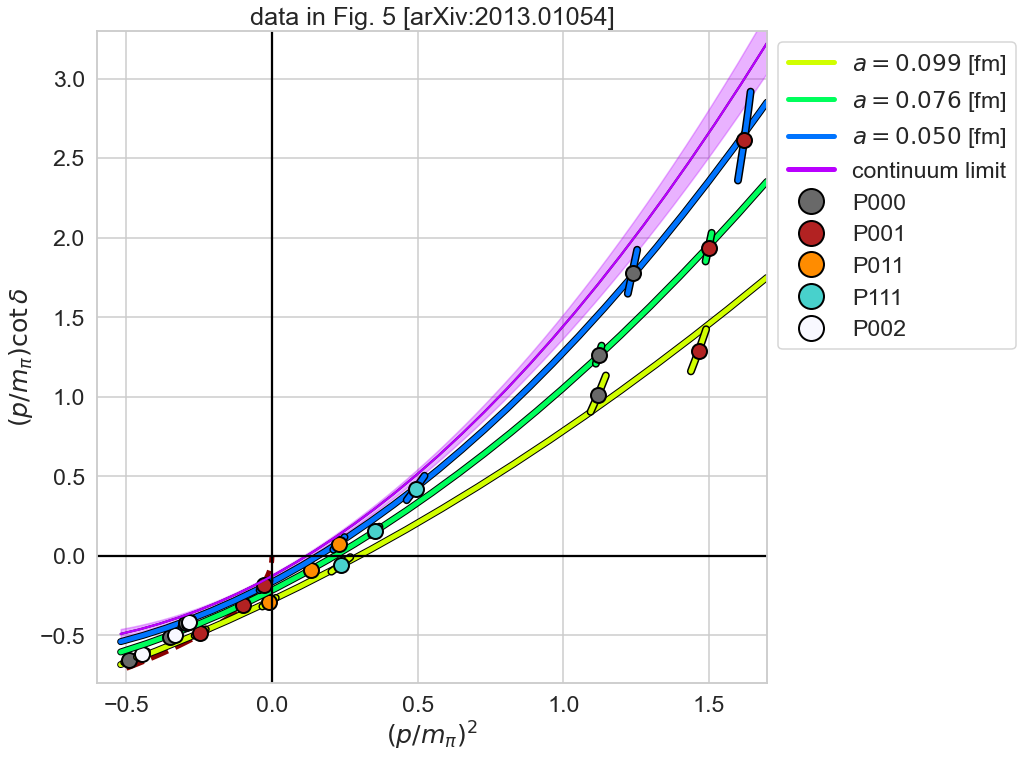

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))


for i, label in enumerate([r'$a = 0.099$ [fm]', r'$a = 0.076$ [fm]', r'$a = 0.050$ [fm]', 'continuum limit']):
    ax.plot([np.nan], [np.nan], ls='-', lw=5, label=label, color=color_list2[i])
    
for i, label in enumerate(['a0099', 'a0076', 'a0050']):
    c2 = color_list2[i]
    dat = ere_data.get(label).get('ere')
    ax.plot(dat.get('x'), dat.get('y'), color='black', ls='-', lw=7)

    ax.plot(dat.get('x'), dat.get('y'), color=c2, ls='-', lw=5)

    for level in [0, 1]:
        for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
            c = color_list.get(frame)
            dat = ere_data.get(label).get(f'{frame}_{level}', False)
            if not dat: continue
            ax.plot(dat.get('xs'), dat.get('ys'), lw=8, color='black')
            ax.plot(dat.get('xs'), dat.get('ys'), lw=5, marker='', color=c2)
            ax.plot(dat.get('x'), dat.get('y'), marker='o', ms=15, mew=2, mec='black', color=c)

        
for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
    c = color_list.get(frame)
     
    ax.plot([np.nan], [np.nan], ls='', marker='o', ms=25, mew=2, mec='black', lw=10, color=c, label=frame)

dat = ere_data.get('a0')

ax.fill_between(dat.get('ere_band').get('x'),
               dat.get('ere_band').get('upper'),
               dat.get('ere_band').get('lower'), alpha=0.3, color=color_list2[3])
ax.plot(dat.get('ere').get('x'), dat.get('ere').get('y'), lw=2, color='black')

ax.plot(dat.get('ere').get('x'), dat.get('ere').get('y'), color=color_list2[3])

xls = np.concatenate([np.linspace(-0.5, -0.05), np.linspace(-0.05, -1e-6)])
ax.plot(xls, - np.sqrt(-xls), color='darkred', ls='--', lw=5, zorder=1)
            
    
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set(xlabel=r'$(p/m_\pi)^2$', ylabel=r'$(p/m_\pi)\cot\delta$')
ax.set(xlim=(-0.6, 1.7), ylim=(-0.8, 3.3), title='data in Fig. 5 [arXiv:2013.01054]')
fig.savefig('../figs/FIG5_crosscheck/p2_vs_pcot_delta_in_Fig5.png', bbox_inches='tight')

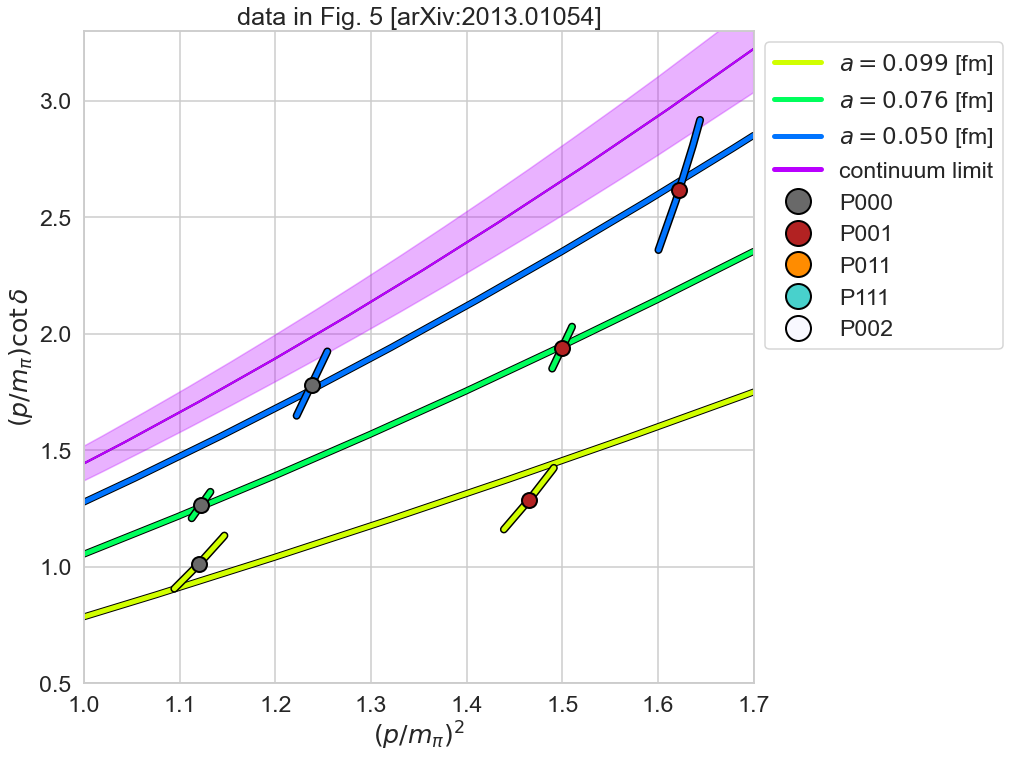

In [16]:
fig, ax = plt.subplots(figsize=(12, 12))


for i, label in enumerate([r'$a = 0.099$ [fm]', r'$a = 0.076$ [fm]', r'$a = 0.050$ [fm]', 'continuum limit']):
    ax.plot([np.nan], [np.nan], ls='-', lw=5, label=label, color=color_list2[i])
    
for i, label in enumerate(['a0099', 'a0076', 'a0050']):
    c2 = color_list2[i]
    dat = ere_data.get(label).get('ere')
    ax.plot(dat.get('x'), dat.get('y'), color='black', ls='-', lw=7)

    ax.plot(dat.get('x'), dat.get('y'), color=c2, ls='-', lw=5)

    for level in [0, 1]:
        for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
            c = color_list.get(frame)
            dat = ere_data.get(label).get(f'{frame}_{level}', False)
            if not dat: continue
            ax.plot(dat.get('xs'), dat.get('ys'), lw=8, color='black')
            ax.plot(dat.get('xs'), dat.get('ys'), lw=5, marker='', color=c2)
            ax.plot(dat.get('x'), dat.get('y'), marker='o', ms=15, mew=2, mec='black', color=c)

        
for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
    c = color_list.get(frame)
     
    ax.plot([np.nan], [np.nan], ls='', marker='o', ms=25, mew=2, mec='black', lw=10, color=c, label=frame)

dat = ere_data.get('a0')

ax.fill_between(dat.get('ere_band').get('x'),
               dat.get('ere_band').get('upper'),
               dat.get('ere_band').get('lower'), alpha=0.3, color=color_list2[3])
ax.plot(dat.get('ere').get('x'), dat.get('ere').get('y'), lw=2, color='black')

ax.plot(dat.get('ere').get('x'), dat.get('ere').get('y'), color=color_list2[3])

xls = np.concatenate([np.linspace(-0.5, -0.05), np.linspace(-0.05, -1e-6)])
ax.plot(xls, - np.sqrt(-xls), color='darkred', ls='--', lw=5, zorder=1)
            
    
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set(xlabel=r'$(p/m_\pi)^2$', ylabel=r'$(p/m_\pi)\cot\delta$')
ax.set(xlim=(1.0, 1.7), ylim=(0.5, 3.3), title='data in Fig. 5 [arXiv:2013.01054]')
fig.savefig('../figs/FIG5_crosscheck/p2_vs_pcot_delta_in_Fig5_excited_state.png', bbox_inches='tight')

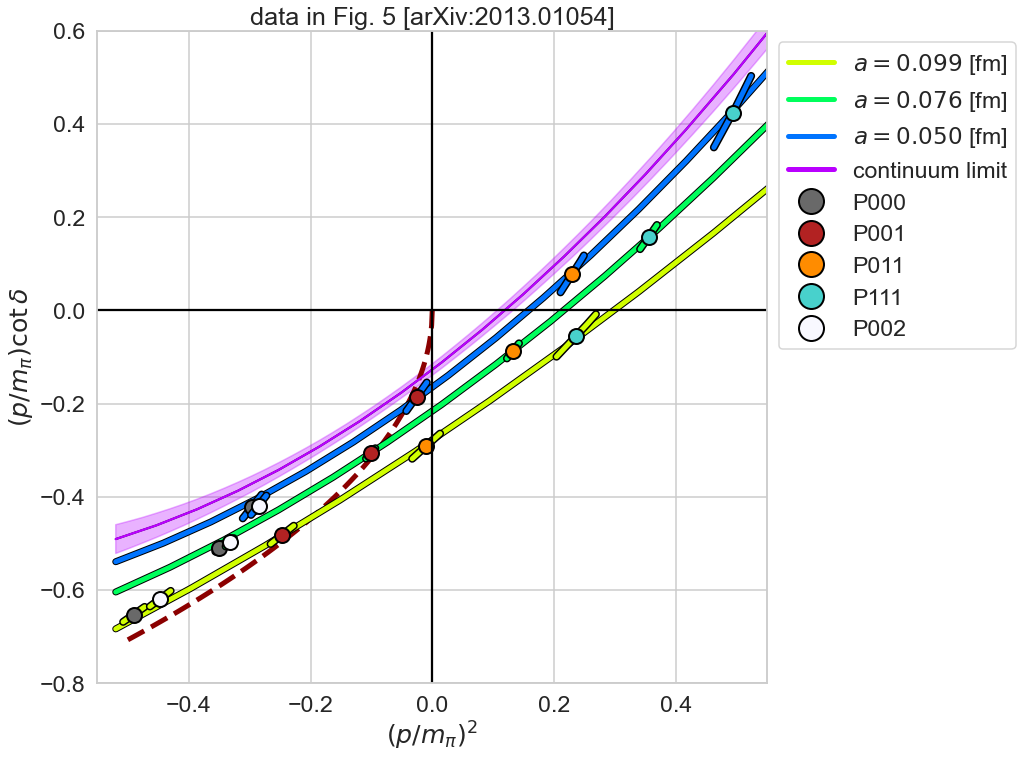

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))


for i, label in enumerate([r'$a = 0.099$ [fm]', r'$a = 0.076$ [fm]', r'$a = 0.050$ [fm]', 'continuum limit']):
    ax.plot([np.nan], [np.nan], ls='-', lw=5, label=label, color=color_list2[i])
    
for i, label in enumerate(['a0099', 'a0076', 'a0050']):
    c2 = color_list2[i]
    dat = ere_data.get(label).get('ere')
    ax.plot(dat.get('x'), dat.get('y'), color='black', ls='-', lw=7)

    ax.plot(dat.get('x'), dat.get('y'), color=c2, ls='-', lw=5)

    for level in [0, 1]:
        for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
            c = color_list.get(frame)
            dat = ere_data.get(label).get(f'{frame}_{level}', False)
            if not dat: continue
            ax.plot(dat.get('xs'), dat.get('ys'), lw=8, color='black')
            ax.plot(dat.get('xs'), dat.get('ys'), lw=5, marker='', color=c2)
            ax.plot(dat.get('x'), dat.get('y'), marker='o', ms=15, mew=2, mec='black', color=c)

        
for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
    c = color_list.get(frame)
     
    ax.plot([np.nan], [np.nan], ls='', marker='o', ms=25, mew=2, mec='black', lw=10, color=c, label=frame)

dat = ere_data.get('a0')

ax.fill_between(dat.get('ere_band').get('x'),
               dat.get('ere_band').get('upper'),
               dat.get('ere_band').get('lower'), alpha=0.3, color=color_list2[3])
ax.plot(dat.get('ere').get('x'), dat.get('ere').get('y'), lw=2, color='black')

ax.plot(dat.get('ere').get('x'), dat.get('ere').get('y'), color=color_list2[3])

xls = np.concatenate([np.linspace(-0.5, -0.05), np.linspace(-0.05, -1e-6)])
ax.plot(xls, - np.sqrt(-xls), color='darkred', ls='--', lw=5, zorder=1)
            
    
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set(xlabel=r'$(p/m_\pi)^2$', ylabel=r'$(p/m_\pi)\cot\delta$')
ax.set(xlim=(-0.55, 0.55), ylim=(-0.8, 0.6), title='data in Fig. 5 [arXiv:2013.01054]')
fig.savefig('../figs/FIG5_crosscheck/p2_vs_pcot_delta_in_Fig5_gss.png', bbox_inches='tight')

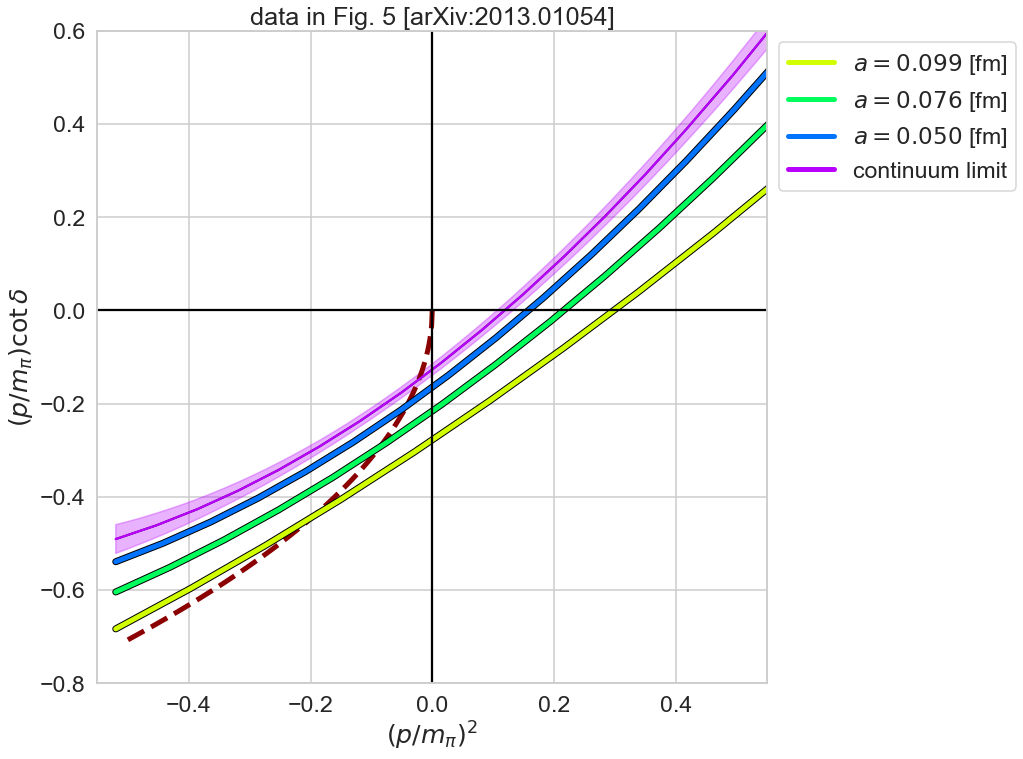

In [18]:
fig, ax = plt.subplots(figsize=(12, 12))


for i, label in enumerate([r'$a = 0.099$ [fm]', r'$a = 0.076$ [fm]', r'$a = 0.050$ [fm]', 'continuum limit']):
    ax.plot([np.nan], [np.nan], ls='-', lw=5, label=label, color=color_list2[i])
    
for i, label in enumerate(['a0099', 'a0076', 'a0050']):
    c2 = color_list2[i]
    dat = ere_data.get(label).get('ere')
    ax.plot(dat.get('x'), dat.get('y'), color='black', ls='-', lw=7)
    ax.plot(dat.get('x'), dat.get('y'), color=c2, ls='-', lw=5)


dat = ere_data.get('a0')

ax.fill_between(dat.get('ere_band').get('x'),
               dat.get('ere_band').get('upper'),
               dat.get('ere_band').get('lower'), alpha=0.3, color=color_list2[3])
ax.plot(dat.get('ere').get('x'), dat.get('ere').get('y'), lw=2, color='black')

ax.plot(dat.get('ere').get('x'), dat.get('ere').get('y'), color=color_list2[3])

xls = np.concatenate([np.linspace(-0.5, -0.05), np.linspace(-0.05, -1e-6)])
ax.plot(xls, - np.sqrt(-xls), color='darkred', ls='--', lw=5, zorder=1)
            
    
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set(xlabel=r'$(p/m_\pi)^2$', ylabel=r'$(p/m_\pi)\cot\delta$')
ax.set(xlim=(-0.55, 0.55), ylim=(-0.8, 0.6), title='data in Fig. 5 [arXiv:2013.01054]')
fig.savefig('../figs/FIG5_crosscheck/p2_vs_pcot_delta_in_Fig5_ERE.png', bbox_inches='tight')

# parameters of ERE

\begin{equation}
(p/m_\pi)\cot\delta = \frac{1}{a_0m_\pi} + \frac{1}{2} r_\mathrm{eff}m_\pi (p/m_\pi)^2 + v_2 m_\pi^3 (p/m_\pi)^4
\end{equation}

In [19]:
ere = lambda p, x: p[0] + 0.5 * p[1]*x + p[2]*x**2
errf = lambda p, y, x: ere(p, x) - y

a0099 [-0.27850402  1.75206236  0.18641927] -0.19700185583582097
a0076 [-0.21653365  1.85101839  0.34481116] -0.08638188741271305
a0050 [-0.16539811  1.93305289  0.4752265 ] -0.04214221142192992
a0 [-0.12729296  1.99388656  0.57261552] -0.022261397354808192


[(-0.55, 1.7),
 (-0.8, 3.3),
 Text(0.5, 1.0, 'data in Fig. 5 [arXiv:2013.01054]')]

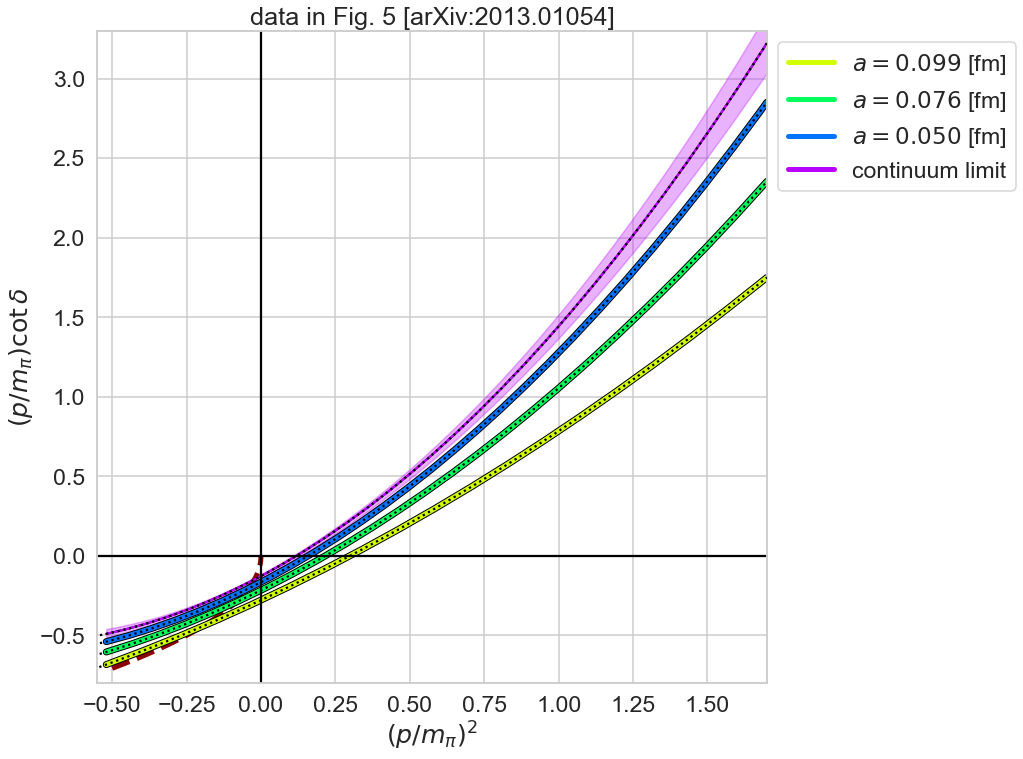

In [20]:
ere_params = {}

fig, ax = plt.subplots(figsize=(12, 12))

xls = np.linspace(-0.6, 1.7)
for i, label in enumerate([r'$a = 0.099$ [fm]', r'$a = 0.076$ [fm]', r'$a = 0.050$ [fm]', 'continuum limit']):
    ax.plot([np.nan], [np.nan], ls='-', lw=5, label=label, color=color_list2[i])
    
for i, label in enumerate(['a0099', 'a0076', 'a0050']):
    c2 = color_list2[i]
    dat = ere_data.get(label).get('ere')
    
    xs, ys = dat.get('x'), dat.get('y')
    pfit = scipy.optimize.leastsq(errf, [-1,0,0], args=(ys, xs), full_output=True)
    
    intersect = lambda x: ere(pfit[0], x) - (- np.sqrt(-x))
    k2star = scipy.optimize.root(intersect, -0.1).x[0]

    print(label, pfit[0], k2star)

    ere_params[label] = np.r_[pfit[0], k2star]
    ax.plot(xls, ere(pfit[0], xls), color='black', ls=':', zorder=5)
    ax.plot(dat.get('x'), dat.get('y'), color='black', ls='-', lw=7)
    ax.plot(dat.get('x'), dat.get('y'), color=c2, ls='-', lw=5)


dat = ere_data.get('a0')

ax.fill_between(dat.get('ere_band').get('x'),
               dat.get('ere_band').get('upper'),
               dat.get('ere_band').get('lower'), alpha=0.3, color=color_list2[3])
ax.plot(dat.get('ere').get('x'), dat.get('ere').get('y'), lw=2, color='black')

ax.plot(dat.get('ere').get('x'), dat.get('ere').get('y'), color=color_list2[3])

xs, ys = dat.get('ere').get('x'), dat.get('ere').get('y')
pfit = scipy.optimize.leastsq(errf, [-1,0,0], args=(ys, xs), full_output=True)

intersect = lambda x: ere(pfit[0], x) - (- np.sqrt(-x))
k2star = scipy.optimize.root(intersect, -0.01).x[0]

print('a0', pfit[0], k2star)

ere_params['a0'] = np.r_[pfit[0], k2star]
ax.plot(xls, ere(pfit[0], xls), color='black', ls=':', zorder=5)


xls = np.concatenate([np.linspace(-0.5, -0.05), np.linspace(-0.05, -1e-6)])
ax.plot(xls, - np.sqrt(-xls), color='darkred', ls='--', lw=5, zorder=1)
    
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set(xlabel=r'$(p/m_\pi)^2$', ylabel=r'$(p/m_\pi)\cot\delta$')
ax.set(xlim=(-0.55, 1.7), ylim=(-0.8, 3.3), title='data in Fig. 5 [arXiv:2013.01054]')
#fig.savefig('check_fig5.png', bbox_inches='tight', transparent=True)


In [21]:
ere_params

{'a0099': array([-0.27850402,  1.75206236,  0.18641927, -0.19700186]),
 'a0076': array([-0.21653365,  1.85101839,  0.34481116, -0.08638189]),
 'a0050': array([-0.16539811,  1.93305289,  0.4752265 , -0.04214221]),
 'a0': array([-0.12729296,  1.99388656,  0.57261552, -0.0222614 ])}

In [22]:
m_pi = 0.420 # pion mass

m_B = 1.19 # baryon mass

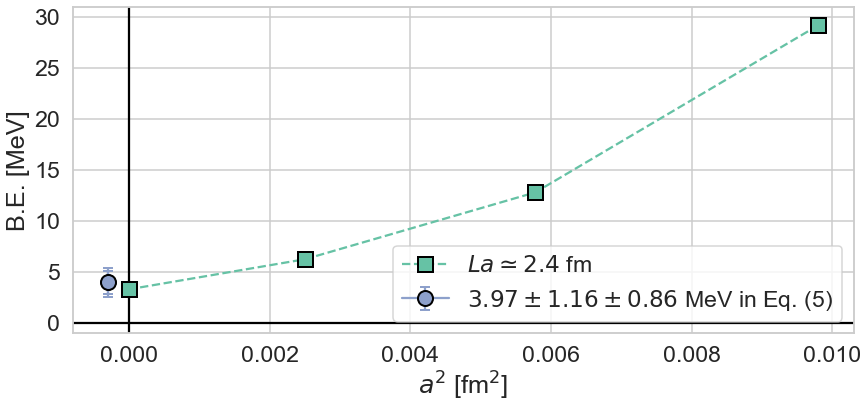

In [23]:
fig, ax = plt.subplots()

xs = []
ys = []
for key, lat in zip(['a0099', 'a0076', 'a0050', 'a0'], [0.099, 0.076, 0.050, 0]):
    dat = ere_params.get(key)
    xs.append(lat**2)
    ys.append(- dat[3] * m_pi**2 / m_B * 1e3) # BE = - (k^ast/m_pi)^2 * m_pi^2 / m_B

ax.plot(xs, ys, ls='--', marker='s', mew=2, mec='black', ms=15, label=fr'$La \simeq 2.4$ fm')

ax.errorbar([-3e-4], [3.97], [np.sqrt(1.16**2+0.86**2)], marker='o', mec='black', ms=15, capthick=2, capsize=5,
           color='C2')

ax.errorbar([-3e-4], [3.97], [1.16], marker='o', mec='black', ms=15, mew=2, capthick=2, capsize=5,
           label=r'$3.97 \pm 1.16 \pm 0.86$ MeV in Eq. (5)', color='C2')

ax.axhline(0, color='black')
ax.axvline(0, color='black', zorder=1)
ax.legend()
ax.set(xlabel=r'$a^2$ [fm$^2$]', ylabel=r'B.E. [MeV]', ylim=(-1, 31))
fig.savefig('../figs/FIG5_crosscheck/BE_a2_dep_in_Fig5.png', bbox_inches='tight')

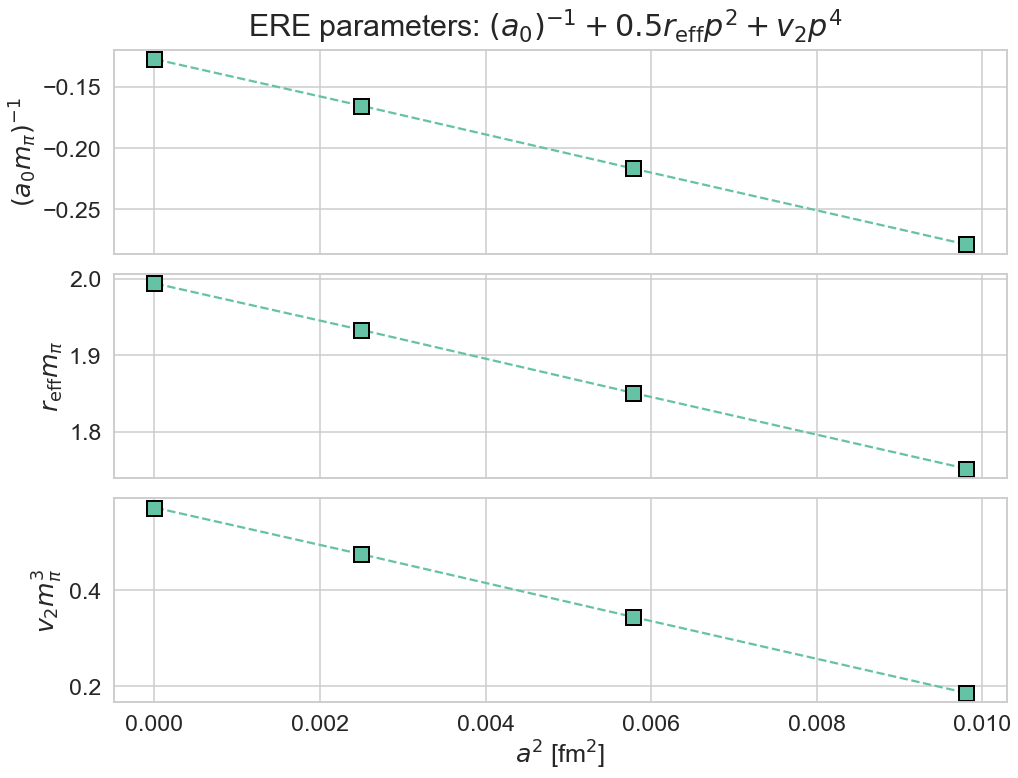

In [24]:
fig, axes = plt.subplots(3,1, figsize=(16,12), sharex=True)

xs = []
ys1 = []
ys2 = []
ys3 = []
ys4 = []
for key, lat in zip(['a0099', 'a0076', 'a0050', 'a0'], [0.099, 0.076, 0.050, 0]):
    dat = ere_params.get(key)
    xs.append(lat**2)
    ys1.append(dat[0])
    ys2.append(dat[1])
    ys3.append(dat[2])
    ys4.append(dat[3])
    

axes[0].plot(xs, ys1, ls='--', marker='s', mew=2, mec='black', ms=15)
axes[1].plot(xs, ys2, ls='--', marker='s', mew=2, mec='black', ms=15)
axes[2].plot(xs, ys3, ls='--', marker='s', mew=2, mec='black', ms=15)

    
axes[0].set(xlabel='', ylabel=r'$(a_0m_\pi)^{-1}$')
axes[1].set(xlabel='', ylabel=r'$r_\mathrm{eff}m_\pi$')
axes[2].set(xlabel=r'$a^2$ [fm$^2$]', ylabel=r'$v_2m_\pi^3$')


plt.subplots_adjust(hspace=0.1)
fig.suptitle(r'ERE parameters: $(a_0)^{-1} + 0.5r_\mathrm{eff}p^2+v_2p^4$', y=0.93)
fig.savefig('../figs/FIG5_crosscheck/ERE_params_in_Fig5.png', bbox_inches='tight')

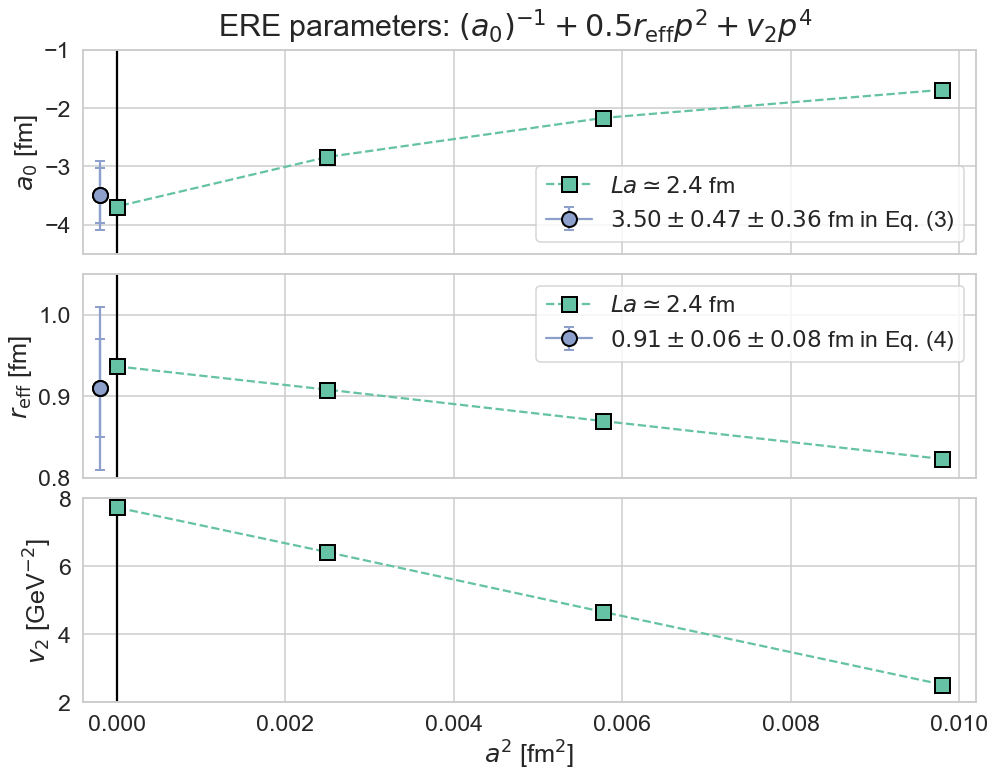

In [25]:
fig, axes = plt.subplots(3,1, figsize=(16, 12), sharex=True)

xs = []
ys1 = []
ys2 = []
ys3 = []
ys4 = []
for key, lat in zip(['a0099', 'a0076', 'a0050', 'a0'], [0.099, 0.076, 0.050, 0]):
    dat = ere_params.get(key)
    xs.append(lat**2)
    ys1.append(hbarc/(m_pi*dat[0]))
    ys2.append(dat[1]/m_pi * hbarc)
    ys3.append(dat[2]/m_pi**3)
    

axes[0].axvline(0, color='black')
axes[0].plot(xs, ys1, ls='--', marker='s', mew=2, mec='black', ms=15, label=r'$La \simeq 2.4$ fm')
axes[0].errorbar([-2e-4], [-3.50], [np.sqrt(0.47**2+0.36**2)], marker='o', mec='black', mew=2, ms=15, capthick=2, capsize=5,
                 color='C2')
axes[0].errorbar([-2e-4], [-3.50], [0.47], marker='o', mec='black', ms=15, mew=2, capthick=2, capsize=5,
           label=r'$3.50 \pm 0.47 \pm 0.36$ fm in Eq. (3)', color='C2')
axes[0].legend()


axes[1].axvline(0, color='black')
axes[1].plot(xs, ys2, ls='--', marker='s', mew=2, mec='black', ms=15, label=r'$La \simeq 2.4$ fm')
axes[1].errorbar([-2e-4], [0.91], [np.sqrt(0.06**2+0.08**2)], marker='o', mew=2, mec='black', ms=15, capthick=2, capsize=5,
                 color='C2')
axes[1].errorbar([-2e-4], [0.91], [0.06], marker='o', mec='black', ms=15,mew=2, capthick=2, capsize=5,
           label=r'$0.91 \pm 0.06 \pm 0.08$ fm in Eq. (4)', color='C2')
axes[1].legend()



axes[2].axvline(0, color='black')
axes[2].plot(xs, ys3, ls='--', marker='s', mew=2, mec='black', ms=15)

    
axes[0].set(xlabel='', ylabel=r'$a_0$ [fm]', ylim=(-4.5, -1), xlim=(-4e-4, 0.0102))
axes[1].set(xlabel='', ylabel=r'$r_\mathrm{eff}$ [fm]', ylim=(0.8, 1.05))
axes[2].set(xlabel=r'$a^2$ [fm$^2$]', ylabel=r'$v_2$ [GeV$^{-2}$]', ylim=(2, 8))

plt.subplots_adjust(hspace=0.1)
fig.suptitle(r'ERE parameters: $(a_0)^{-1} + 0.5r_\mathrm{eff}p^2+v_2p^4$', y=0.93)
fig.savefig('../figs/FIG5_crosscheck/ERE_params_phys_scale_in_Fig5.png', bbox_inches='tight')